In [0]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', 105)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline
sns.set()
from sklearn.model_selection import train_test_split #to split the dataset for training and testing
from sklearn import metrics #for checking the model accuracy
from sklearn.metrics import mean_squared_error #for checking the model accuracy
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [0]:
#!apt-get -y install fonts-ipafont-gothic


In [0]:
#!rm /root/.cache/matplotlib/fontList.json
#!rm /root/.cache/matplotlib/fontlist-v300.json


In [0]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
#train.head(3)

In [0]:
train = train.rename(columns={'賃料':'Rent', '契約期間':'Contract', '間取り':'Type', 
                              '築年数':'Age', '駐車場':'Parking', '室内設備':'Facility', 
                              '放送・通信':'Internet', '周辺環境':'Surround', '建物構造':'Material', 
                              '面積':'Area', 'キッチン':'Kitchen', '所在地':'Location',
                              'バス・トイレ':'Bath', '所在階':'Floor', 'アクセス':'Access', 
                              '方角':'Direction'})
test = test.rename(columns={'契約期間':'Contract', '間取り':'Type', 
                              '築年数':'Age', '駐車場':'Parking', '室内設備':'Facility', 
                              '放送・通信':'Internet', '周辺環境':'Surround', '建物構造':'Material', 
                              '面積':'Area', 'キッチン':'Kitchen', '所在地':'Location',
                              'バス・トイレ':'Bath', '所在階':'Floor', 'アクセス':'Access', 
                              '方角':'Direction'})

In [4]:
train.shape, test.shape

((31470, 17), (31262, 16))

In [0]:
train = train.drop([5775,20926],axis = 0)

In [0]:
train = train.drop([20231,20427],axis = 0)


In [0]:
train_test_data = [train, test]# combining train and test dataset
for dataset in train_test_data:
    dataset['City'] = dataset['Location'].str.extract('(千代田区|中央区|港区|新宿区|文京区|'
                                                 '台東区|墨田区|江東区|品川区|目黒区|'
                                                 '大田区|世田谷区|渋谷区|中野区|杉並区|'
                                                 '豊島区|北区|荒川区|板橋区|練馬区|足立区|葛飾区|江戸川区)')

In [0]:
for dataset in train_test_data:
    dataset['Station'] = dataset['Access'].str.extract('(\w+?駅)').fillna('三軒茶屋駅')
    dataset['Line'] = dataset['Access'].str.extract('(\w+?線)').fillna('山手')
    dataset['MinWalk'] = dataset['Access'].str.extract('((?<=徒歩).+?(?=分))').fillna('-1').astype(int)
    #dataset['MinBus'] = dataset['Access'].str.extract('((?<=バス\().+?(?=分\)))').fillna('-1').astype(int)

In [0]:
for dataset in train_test_data:
    dataset['StationCount'] = dataset['Access'].map(lambda x: x.count('駅\t'))
   # dataset['LineCount'] = dataset['Access'].map(lambda x: x.count('線')+x.count('ライン')+x.count('エクスプレス')+x.count('ライナー')+x.count('ゆりかもめ'))


In [10]:
test['StationCount'].value_counts()

3    27717
2     2046
1     1499
Name: StationCount, dtype: int64

In [11]:
i = '西巣鴨駅'
train['Access'].str.extract('({}\t*?徒歩\d*分)'.format(i)).head(1)


0
0  西巣鴨駅\t徒歩4分

<Figure size 3600x2160 with 0 Axes>

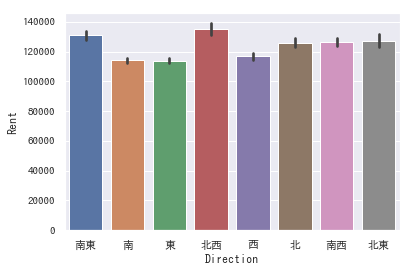

<Figure size 3600x2160 with 0 Axes>

In [12]:
sns.set(font='IPAGothic')
sns.barplot(x='Direction',y='Rent',data=train)
plt.figure(figsize=(50,30))


In [0]:
for dataset in train_test_data:
    dataset['Direction'].fillna('南',inplace=True)

In [0]:
for dataset in train_test_data:
    dataset['R'] = dataset['Type'].str.extract('([0-9]*)').fillna('-1').astype(int)
    dataset['K'] = dataset['Type'].apply(lambda x: 'K' in x)
    dataset['L'] = dataset['Type'].apply(lambda x: 'L' in x)
    dataset['D'] = dataset['Type'].apply(lambda x: 'D' in x)
    dataset['S'] = dataset['Type'].apply(lambda x: 'S' in x)

In [15]:
train['K'].value_counts()

True     26384
False     5082
Name: K, dtype: int64

In [16]:
train['R'].value_counts()

1    24055
2     5562
3     1666
4      156
5       25
6        2
Name: R, dtype: int64

In [0]:
for dataset in train_test_data:
    dataset['NewConstr'] = (dataset['Age']=='新築')
    dataset['Year'] = dataset['Age'].str.extract('([0-9]*年)')
    dataset['Year'] = dataset['Year'].str.extract('([0-9]*)').fillna('0').astype(int)
    dataset['Month'] = dataset['Age'].str.extract('([0-9]*ヶ月)')
    dataset['Month'] = dataset['Month'].str.extract('([0-9]*)').fillna('0').astype(int)
    dataset['Month'] = dataset['Year']*12+dataset['Month']


In [0]:
for dataset in train_test_data:
    dataset['Area'] = dataset['Area'].str.extract('(-?\d+\.?\d*)').astype(float)

In [0]:
for dataset in train_test_data:
    dataset['FloorTh'] = dataset['Floor'].str.extract(r'(\d+)?階／', expand=False).fillna('0').astype(int)
    dataset['FloorNum'] = dataset['Floor'].str.extract(r'(\d+)?階建', expand=False).fillna('0').astype(int)
    #dataset['UndergroundTh'] = dataset['Floor'].str.extract(r'^地下(\d+)?階', expand=False).fillna('0').astype(int)
    dataset['UndergroundNum'] = dataset['Floor'].str.extract(r'地下(\d+)?階', expand=False).fillna('0').astype(int)
    #dataset['House'] = dataset['Floor'].str.extract('((?!／)^.\d*階建)')
    dataset['House'] = dataset['Floor'].str.match('((?!／)^.\d*階建)').astype(bool)

In [0]:
for dataset in train_test_data:
    #dataset['Contract'] = dataset['Contract'].str.extract('([0-9]*ヶ月)')
    dataset['Contract'] = dataset['Contract'].str.replace('2019年', '0年', regex=True)
    dataset['Contract'] = dataset['Contract'].str.replace('2020年', '1年', regex=True)
    dataset['Contract'] = dataset['Contract'].str.replace('2021年', '2年', regex=True)
    dataset['Contract'] = dataset['Contract'].str.replace('2022年', '3年', regex=True)
    dataset['Contract'] = dataset['Contract'].str.replace('2023年', '4年', regex=True)
    dataset['Contract'] = dataset['Contract'].str.replace('2024年', '5年', regex=True)

In [0]:
for dataset in train_test_data:
    dataset['YearContract'] = dataset['Contract'].str.extract('([0-9]*年間)')
    dataset['YearContract'] = dataset['YearContract'].str.extract('([0-9]*)').fillna('2').astype(int)
    dataset['MonthContract'] = dataset['Contract'].str.extract('([0-9]*ヶ月)')
    dataset['MonthContract'] = dataset['MonthContract'].str.extract('([0-9]*)').fillna('0').astype(int)
    dataset['MonthContract'] = dataset['YearContract']*12+dataset['MonthContract']
    dataset['fixedterm'] = dataset['Contract'].str.extract('(定期借家)')
    dataset['fixedterm'] = dataset['fixedterm'].apply(lambda x: True if x == '定期借家' else False)


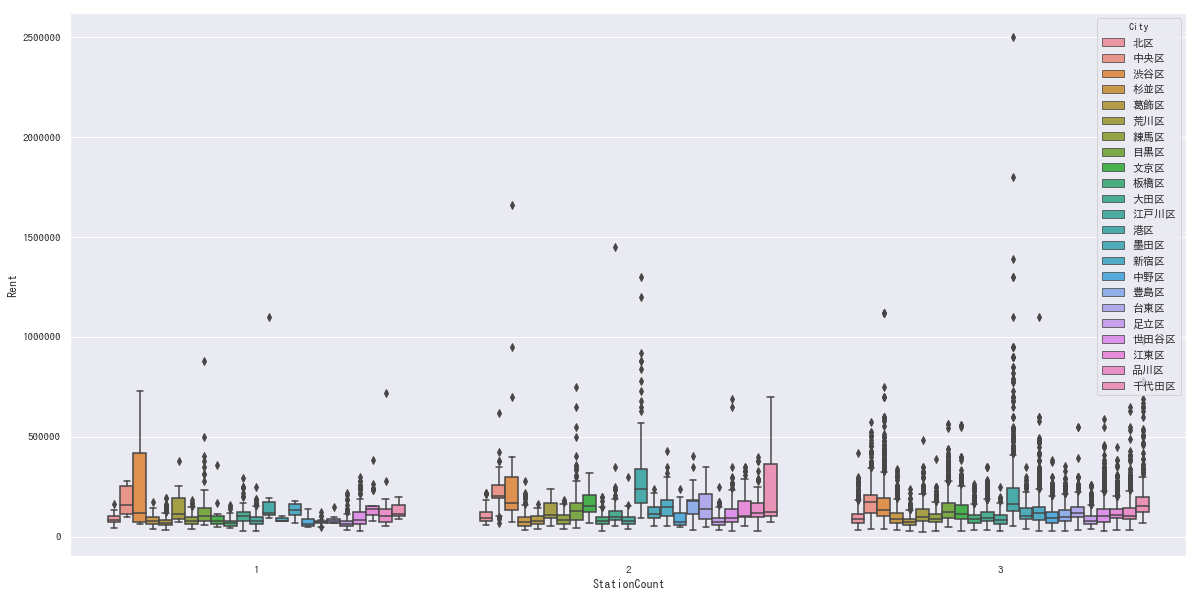

In [22]:
sns.set(font='IPAGothic')
plt.figure(figsize=(20,10))
sns.boxplot(x = 'StationCount',y='Rent',hue='City',data=train)


In [0]:
 for dataset in train_test_data:
    dataset['warmseat'] = dataset['Bath'].str.extract('(温水洗浄便座)')
    dataset['shower'] = dataset['Bath'].str.extract('(シャワー)')
    dataset['dryer'] = dataset['Bath'].str.extract('(浴室乾燥機)')
    dataset['bathtoilet'] = dataset['Bath'].str.extract('(バス・トイレ別)')
    dataset['memorial'] = dataset['Bath'].str.extract('(追焚機能)')
    dataset['washstand'] = dataset['Bath'].str.extract('(洗面台独立)')
    dataset['dressing'] = dataset['Bath'].str.extract('(脱衣所)')
    dataset['toilet'] = dataset['Bath'].str.extract('(専用トイレ|トイレなし|共同トイレ)').fillna('トイレなし')
    dataset['bath'] = dataset['Bath'].str.extract('(専用バス|バスなし|共同バス)').fillna('バスなし')

In [0]:
 for dataset in train_test_data:
    dataset['warmseat'] = dataset['warmseat'].apply(lambda x: True if x == '温水洗浄便座' else False)
    dataset['shower'] = dataset['shower'].apply(lambda x: True if x == 'シャワー' else False)
    dataset['dryer'] = dataset['dryer'].apply(lambda x: True if x == '浴室乾燥機' else False)
    dataset['bathtoilet'] = dataset['bathtoilet'].apply(lambda x: True if x == 'バス・トイレ別' else False)
    dataset['memorial'] = dataset['memorial'].apply(lambda x: True if x == '追焚機能' else False)
    dataset['washstand'] = dataset['washstand'].apply(lambda x: True if x == '洗面台独立' else False)
    dataset['dressing'] = dataset['dressing'].apply(lambda x: True if x == '脱衣所' else False)

In [25]:
train['warmseat'].value_counts()

True     17543
False    13923
Name: warmseat, dtype: int64

In [0]:
 for dataset in train_test_data:
    dataset['gasstove'] = dataset['Kitchen'].str.extract('(ガスコンロ)')
    dataset['2stovetops'] = dataset['Kitchen'].str.extract('(コンロ2口)')
    dataset['systemkitchen'] = dataset['Kitchen'].str.extract('(システムキッチン)')
    dataset['hotwatersupply'] = dataset['Kitchen'].str.extract('(給湯)')
    dataset['separatekitchen'] = dataset['Kitchen'].str.extract('(独立キッチン)')
    dataset['3stovetops'] = dataset['Kitchen'].str.extract('(コンロ3口)')
    dataset['IH'] = dataset['Kitchen'].str.extract('(IHコンロ)')
    dataset['1stovetop'] = dataset['Kitchen'].str.extract('(コンロ1口)')
    dataset['fridge'] = dataset['Kitchen'].str.extract('(冷蔵庫あり)')
    dataset['installedstove'] = dataset['Kitchen'].str.extract('(コンロ設置可)')
    dataset['counterkitchen'] = dataset['Kitchen'].str.extract('(カウンターキッチン)')
    #dataset['Lshapekitchen'] = dataset['Kitchen'].str.extract('(L字キッチン)')
    #dataset['unknown'] = dataset['Kitchen'].str.extract('(口数不明)')
    #dataset['electricstove'] = dataset['Kitchen'].str.extract('(電気コンロ)')
    dataset['morethan4stoves'] = dataset['Kitchen'].str.extract('(コンロ4口以上)')

In [0]:
for dataset in train_test_data:
    dataset['gasstove'] = dataset['gasstove'].apply(lambda x: True if x == 'ガスコンロ' else False)
    dataset['2stovetops'] = dataset['2stovetops'].apply(lambda x: 2 if x == 'コンロ2口' else 1)
    dataset['systemkitchen'] = dataset['systemkitchen'].apply(lambda x: True if x == 'システムキッチン' else False)
    dataset['hotwatersupply'] = dataset['hotwatersupply'].apply(lambda x: True if x == '給湯' else False)
    dataset['separatekitchen'] = dataset['separatekitchen'].apply(lambda x: True if x == '独立キッチン' else False)
    dataset['3stovetops'] = dataset['3stovetops'].apply(lambda x: 3 if x == 'コンロ3口' else 1)
    dataset['IH'] = dataset['IH'].apply(lambda x: True if x == 'IHコンロ' else False)
    dataset['1stovetop'] = dataset['1stovetop'].apply(lambda x: 1 if x == 'コンロ1口' else 1)
    dataset['fridge'] = dataset['fridge'].apply(lambda x: True if x == '冷蔵庫あり' else False)
    dataset['installedstove'] = dataset['installedstove'].apply(lambda x: True if x == 'コンロ設置可' else False)
    dataset['counterkitchen'] = dataset['counterkitchen'].apply(lambda x: True if x == 'カウンターキッチン' else False)
  #  dataset['Lshapekitchen'] = dataset['Lshapekitchen'].apply(lambda x: True if x == 'L字キッチン' else False)
  #  dataset['unknown'] = dataset['unknown'].apply(lambda x: True if x == '口数不明' else False)
   # dataset['electricstove'] = dataset['electricstove'].apply(lambda x: True if x == '電気コンロ' else False)
    dataset['morethan4stoves'] = dataset['morethan4stoves'].apply(lambda x: 4 if x == 'コンロ4口以上' else 1)

In [0]:
for dataset in train_test_data:
  dataset['stove'] = dataset['Kitchen'].isna()*(-1)
  dataset['stove'] = dataset['stove'] + (dataset['stove']+1)*dataset[['2stovetops','3stovetops','1stovetop','morethan4stoves']].max(axis=1)

In [0]:
for dataset in train_test_data:            #replace NaN with largest type which is 2
  dataset['stove'] = dataset['stove'].replace(-1,0)

In [0]:
 for dataset in train_test_data:
    dataset['freeusage'] = dataset['Internet'].str.extract('(インターネット使用料無料)')
   # dataset['cable'] = dataset['Internet'].str.extract('(有線放送)')
    dataset['csantenna'] = dataset['Internet'].str.extract('(CSアンテナ)')
    dataset['catv'] = dataset['Internet'].str.extract('(CATV)')
    dataset['opticalfiber'] = dataset['Internet'].str.extract('(光ファイバー)')
    dataset['internetcompatible'] = dataset['Internet'].str.extract('(インターネット対応)')
    dataset['bsantenna'] = dataset['Internet'].str.extract('(BSアンテナ)')
    dataset['highspeed'] = dataset['Internet'].str.extract('(高速インターネット)')


In [0]:
 for dataset in train_test_data:
    dataset['freeusage'] = dataset['freeusage'].apply(lambda x: True if x == 'インターネット使用料無料' else False)
  #  dataset['cable'] = dataset['cable'].apply(lambda x: True if x == '有線放送' else False)
    dataset['csantenna'] = dataset['csantenna'].apply(lambda x: True if x == 'CSアンテナ' else False)
    dataset['catv'] = dataset['catv'].apply(lambda x: True if x == 'CATV' else False)
    dataset['opticalfiber'] = dataset['opticalfiber'].apply(lambda x: True if x == '光ファイバー' else False)
    dataset['internetcompatible'] = dataset['internetcompatible'].apply(lambda x: True if x == 'インターネット対応' else False)
    dataset['bsantenna'] = dataset['bsantenna'].apply(lambda x: True if x == 'BSアンテナ' else False)
    dataset['highspeed'] = dataset['highspeed'].apply(lambda x: True if x == '高速インターネット' else False)

In [0]:
 for dataset in train_test_data:
    #dataset['rentalvideo'] = dataset['Surround'].str.extract('(レンタルビデオ)')
    dataset['park'] = dataset['Surround'].str.extract('(公園)')
    dataset['drugstore'] = dataset['Surround'].str.extract('(ドラッグストア)')
    #dataset['library'] = dataset['Surround'].str.extract('(図書館)')
    dataset['primaryschool'] = dataset['Surround'].str.extract('(小学校)')
    dataset['hospital'] = dataset['Surround'].str.extract('(病院)')
    #dataset['department'] = dataset['Surround'].str.extract('(デパート)')
    dataset['generalhospital'] = dataset['Surround'].str.extract('(総合病院)')
    #dataset['monthlyparkinglot'] = dataset['Surround'].str.extract('(月極駐車場)')
    dataset['restaurant'] = dataset['Surround'].str.extract('(飲食店)')
    dataset['school'] = dataset['Surround'].str.extract('(学校)')
    dataset['konbini'] = dataset['Surround'].str.extract('(コンビニ)')
    dataset['bank'] = dataset['Surround'].str.extract('(銀行)')
    #dataset['cleaning'] = dataset['Surround'].str.extract('(クリーニング)')
    dataset['kindergarten'] = dataset['Surround'].str.extract('(幼稚園・保育園)')
    #dataset['coinparking'] = dataset['Surround'].str.extract('(コインパーキング)')
    #dataset['univ'] = dataset['Surround'].str.extract('(大学)')
    dataset['supermarket'] = dataset['Surround'].str.extract('(スーパー)')
    dataset['postoffice'] = dataset['Surround'].str.extract('(郵便局)')

In [33]:
train['school'].value_counts()

学校    2657
Name: school, dtype: int64

In [0]:
 for dataset in train_test_data:
    #dataset['rentalvideo'] = dataset['rentalvideo'].apply(lambda x: True if x == 'レンタルビデオ' else False)
    dataset['park'] = dataset['park'].apply(lambda x: True if x == '公園' else False)
    dataset['drugstore'] = dataset['drugstore'].apply(lambda x: True if x == 'ドラッグストア' else False)
    #dataset['library'] = dataset['library'].apply(lambda x: True if x == '図書館' else False)
    dataset['primaryschool'] = dataset['primaryschool'].apply(lambda x: True if x == '小学校' else False)
    dataset['hospital'] = dataset['hospital'].apply(lambda x: True if x == '病院' else False)
    #dataset['department'] = dataset['department'].apply(lambda x: True if x == 'デパート' else False)
    dataset['generalhospital'] = dataset['generalhospital'].apply(lambda x: True if x == '総合病院' else False)
    #dataset['monthlyparkinglot'] = dataset['monthlyparkinglot'].apply(lambda x: True if x == '月極駐車場' else False)
    dataset['restaurant'] = dataset['restaurant'].apply(lambda x: True if x == '飲食店' else False)
    dataset['school'] = dataset['school'].apply(lambda x: True if x == '学校' else False)
    dataset['konbini'] = dataset['konbini'].apply(lambda x: True if x == 'コンビニ' else False)
    dataset['bank'] = dataset['bank'].apply(lambda x: True if x == '銀行' else False)
    #dataset['cleaning'] = dataset['cleaning'].apply(lambda x: True if x == 'クリーニング' else False)
    dataset['kindergarten'] = dataset['kindergarten'].apply(lambda x: True if x == '幼稚園・保育園' else False)
    #dataset['coinparking'] = dataset['coinparking'].apply(lambda x: True if x == 'コインパーキング' else False)
    #dataset['univ'] = dataset['univ'].apply(lambda x: True if x == '大学' else False)
    dataset['supermarket'] = dataset['supermarket'].apply(lambda x: True if x == 'スーパー' else False)
    dataset['postoffice'] = dataset['postoffice'].apply(lambda x: True if x == '郵便局' else False)

In [0]:
train_test_data = [train, test]
for dataset in train_test_data:
  dataset['Parking'] = dataset['Parking'].str.replace('駐輪場','a駐輪場')
  dataset['Parking'] = dataset['Parking'].str.replace('駐車場','a駐車場')
  dataset['Parking'] = dataset['Parking'].str.replace('バイク置き場','aバイク置き場')
  dataset['Parking'] = dataset['Parking'] + 'a'

In [0]:
for dataset in train_test_data:
  temp = dataset['Parking'].str.extract('(a駐車場.*?a)')[0]
  dataset['carparking'] = temp.str.extract('(無|空無|近隣|空有)').fillna('無')
  dataset['carparking_distance'] = temp.str.extract('距離(\d*)m').astype(float).fillna(0)
  dataset['carparking_price'] = temp.str.extract('(\d*,\d*)')[0].str.replace(',','').astype(float).fillna(0)
  temp = dataset['Parking'].str.extract('(a駐輪場.*?a)')[0]
  dataset['bikeparking'] = temp.str.extract('(無|空無|近隣|空有)').fillna('無')
  #dataset['bikeparking_distance'] = temp.str.extract('距離(\d*)m').astype(float).fillna(0)
  #dataset['bikeparking_price'] = temp.str.extract('(\d*,\d*)')[0].str.replace(',','').astype(float).fillna(-1)
  temp = dataset['Parking'].str.extract('(aバイク置き場.*?a)')[0]
  dataset['motorparking'] = temp.str.extract('(無|空無|近隣|空有)').fillna('無')
  #dataset['motorparking_distance'] = temp.str.extract('距離(\d*)m').astype(float).fillna(-1)
  #dataset['motorparking_price'] = temp.str.extract('(\d*,\d*)')[0].str.replace(',','').astype(float).fillna(-1)

In [42]:
train[train['Rent']>=1000000]

id     Rent         Location  \
1501    1502  1200000      東京都港区元麻布３丁目   
1771    1772  1450000    東京都大田区田園調布３丁目   
5093    5094  2500000    東京都港区三田２丁目4-3   
8706    8707  1390000  東京都港区虎ノ門５丁目11-1   
9008    9009  1300000  東京都港区麻布台３丁目4-24   
11367  11368  1100000      東京都新宿区新宿６丁目   
11958  11959  1120000      東京都渋谷区広尾１丁目   
15417  15418  1300000  東京都港区南麻布１丁目16-2   
16847  16848  1120000   東京都渋谷区広尾１丁目1-7   
17324  17325  1100000      東京都港区南麻布５丁目   
20024  20025  1100000  東京都港区赤坂８丁目11-38   
20643  20644  1800000    東京都港区三田２丁目4-3   
20989  20990  1300000      東京都港区南麻布４丁目   
25551  25552  1120000   東京都渋谷区広尾１丁目8-7   
30539  30540  1660000      東京都渋谷区広尾１丁目   

                                                  Access        Type      Age  \
1501   南北線\t麻布十番駅\t徒歩9分\t\t都営大江戸線\t六本木駅\t徒歩9分\t\t東京メト...        3LDK   18年6ヶ月   
1771            東急東横線\t田園調布駅\t徒歩5分\t\t東急目黒線\t田園調布駅\t徒歩5分  4LDK+S(納戸)    9年1ヶ月   
5093   南北線\t麻布十番駅\t徒歩8分\t\t都営大江戸線\t赤羽橋駅\t徒歩9分\t\t山手線\...  2LDK+S(納戸)    1年8ヶ月   
8706   日比谷線\t神谷町駅\t徒歩1分\t\t南北線\t六本木一丁目駅\t徒歩10分\t\t都営三...        2LDK  14年10ヶ月   
9008   都営大江戸線\t麻布十番駅\t徒歩7分\t\t南北線\t六本木一丁目駅\t徒歩8分\t\t日...  3LDK+S(納戸)   30年5ヶ月   
11367  都営大江戸線\t東新宿駅\t徒歩2分\t\t都営新宿線\t新宿三丁目駅\t徒歩10分\t\t...        2LDK   25年1ヶ月   
11958  山手線\t恵比寿駅\t徒歩6分\t\t日比谷線\t広尾駅\t徒歩13分\t\t東急東横線\t...        4LDK   22年7ヶ月   
15417  南北線\t麻布十番駅\t徒歩7分\t\t南北線\t白金高輪駅\t徒歩16分\t\t都営大江戸...        2LDK    5年1ヶ月   
16847  山手線\t恵比寿駅\t徒歩6分\t\t日比谷線\t広尾駅\t徒歩14分\t\t東急東横線\t...        4LDK   22年7ヶ月   
17324                                    日比谷線\t広尾駅\t徒歩5分        4LDK    7年0ヶ月   
20024  千代田線\t乃木坂駅\t徒歩2分\t\t日比谷線\t六本木駅\t徒歩8分\t\t銀座線\t青...        3LDK    9年0ヶ月   
20643  南北線\t麻布十番駅\t徒歩8分\t\t都営大江戸線\t赤羽橋駅\t徒歩9分\t\t山手線\...  2LDK+S(納戸)    1年8ヶ月   
20989  日比谷線\t広尾駅\t徒歩8分\t\t南北線\t麻布十番駅\t徒歩18分\t\t山手線恵比寿...        3LDK   14年9ヶ月   
25551  山手線\t恵比寿駅\t徒歩9分\t\t日比谷線\t広尾駅\t徒歩9分\t\t東急東横線\t代...  1LDK+S(納戸)  13年11ヶ月   
30539                山手線\t恵比寿駅\t徒歩6分\t\t日比谷線\t恵比寿駅\t徒歩6分  4LDK+S(納戸)   22年7ヶ月   

      Direction    Area           Floor  \
1501         南東  163.62          3階／3階建   
1771         南西  232.01             2階建   
5093          西  217.29    9階／9階建（地下2階）   
8706          東  138.99         7階／24階建   
9008          南  223.71             3階建   
11367        南東  192.43   9階／10階建（地下1階）   
11958         南  221.30        11階／13階建   
15417         北  125.00          7階／7階建   
16847         東  221.30  11階／13階建（地下2階）   
17324        北東  171.43    3階／4階建（地下1階）   
20024        南西  176.87  25階／25階建（地下1階）   
20643         南  151.81    5階／9階建（地下2階）   
20989        北東  167.99    1階／8階建（地下1階）   
25551         南  144.35   9階／10階建（地下1階）   
30539         南  341.30  12階／13階建（地下2階）   

                                                    Bath  \
1501   専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t浴室乾燥機\t...   
1771                専用バス／\t専用トイレ／\tシャワー／\t温水洗浄便座／\t洗面台独立   
5093   専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t浴室乾燥機\t...   
8706   専用バス／\t専用トイレ／\tシャワー／\t追焚機能／\t浴室乾燥機\t／\t温水洗浄便座／...   
9008   専用バス／\t専用トイレ／\tバス・トイレ別／\t追焚機能／\t浴室乾燥機\t／\t洗面台独...   
11367       バス・トイレ別／\tシャワー／\t追焚機能／\t温水洗浄便座／\t洗面台独立／\t脱衣所   
11958  専用バス／\t専用トイレ／\tシャワー／\t浴室乾燥機\t／\t温水洗浄便座／\t洗面台独立...   
15417  専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t浴室乾燥機\t...   
16847  専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t温水洗浄便座／...   
17324  専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t浴室乾燥機\t...   
20024  専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t浴室乾燥機\t...   
20643  専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t浴室乾燥機\t...   
20989  専用バス／\t専用トイレ／\tシャワー／\t追焚機能／\t浴室乾燥機\t／\t温水洗浄便座／...   
25551  専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t浴室乾燥機\t...   
30539                                             温水洗浄便座   

                                                 Kitchen  \
1501                             ガスコンロ／\tシステムキッチン\t／\t給湯   
1771                             ガスコンロ／\tシステムキッチン\t／\t給湯   
5093   IHコンロ\t／\tコンロ3口／\tシステムキッチン\t／\tカウンターキッチン\t／\tL...   
8706            ガスコンロ／\tコンロ3口／\tシステムキッチン\t／\t給湯／\t独立キッチン   
9008                 ガスコンロ／\tコンロ3口／\tシステムキッチン\t／\tL字キッチン   
11367                         

<Figure size 3600x2160 with 0 Axes>

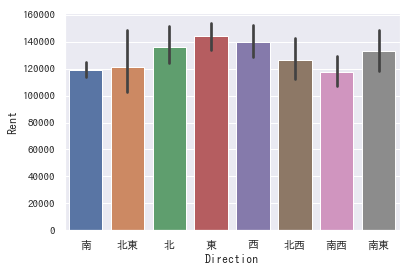

<Figure size 3600x2160 with 0 Axes>

In [101]:
sns.set(font='IPAGothic')
x = train[(train['Rent']<1000000)&(train['City']=='新宿区')]
sns.barplot(x='Direction',y='Rent',data=x)
plt.figure(figsize=(50,30))


In [103]:
train['Facility'].value_counts()

RC（鉄筋コンクリート）                   17504
木造                              5512
鉄骨造                             3723
SRC（鉄骨鉄筋コンクリート）                 2429
軽量鉄骨                            1812
ALC（軽量気泡コンクリート）                  297
その他                              136
PC（プレキャスト・コンクリート（鉄筋コンクリート））       46
HPC（プレキャスト・コンクリート（重量鉄骨））           4
ブロック                               3
Name: Material, dtype: int64

In [63]:

x[['City','Rent']].groupby('City').mean().sort_values('Rent')


Rent
City               
葛飾区    79114.657591
足立区    85872.540849
江戸川区   86592.302585
板橋区    89990.326556
練馬区    92724.943493
杉並区    97708.174675
北区     99506.602871
中野区   101578.398018
大田区   106309.829915
豊島区   110916.884343
世田谷区  113781.270261
墨田区   116201.346535
荒川区   116819.304348
品川区   124609.473270
江東区   126217.110743
台東区   127625.944206
文京区   128562.070628
新宿区   129780.646481
目黒区   145736.692759
渋谷区   167423.231397
中央区   180887.865520
千代田区  182706.236324
港区    206042.528277

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


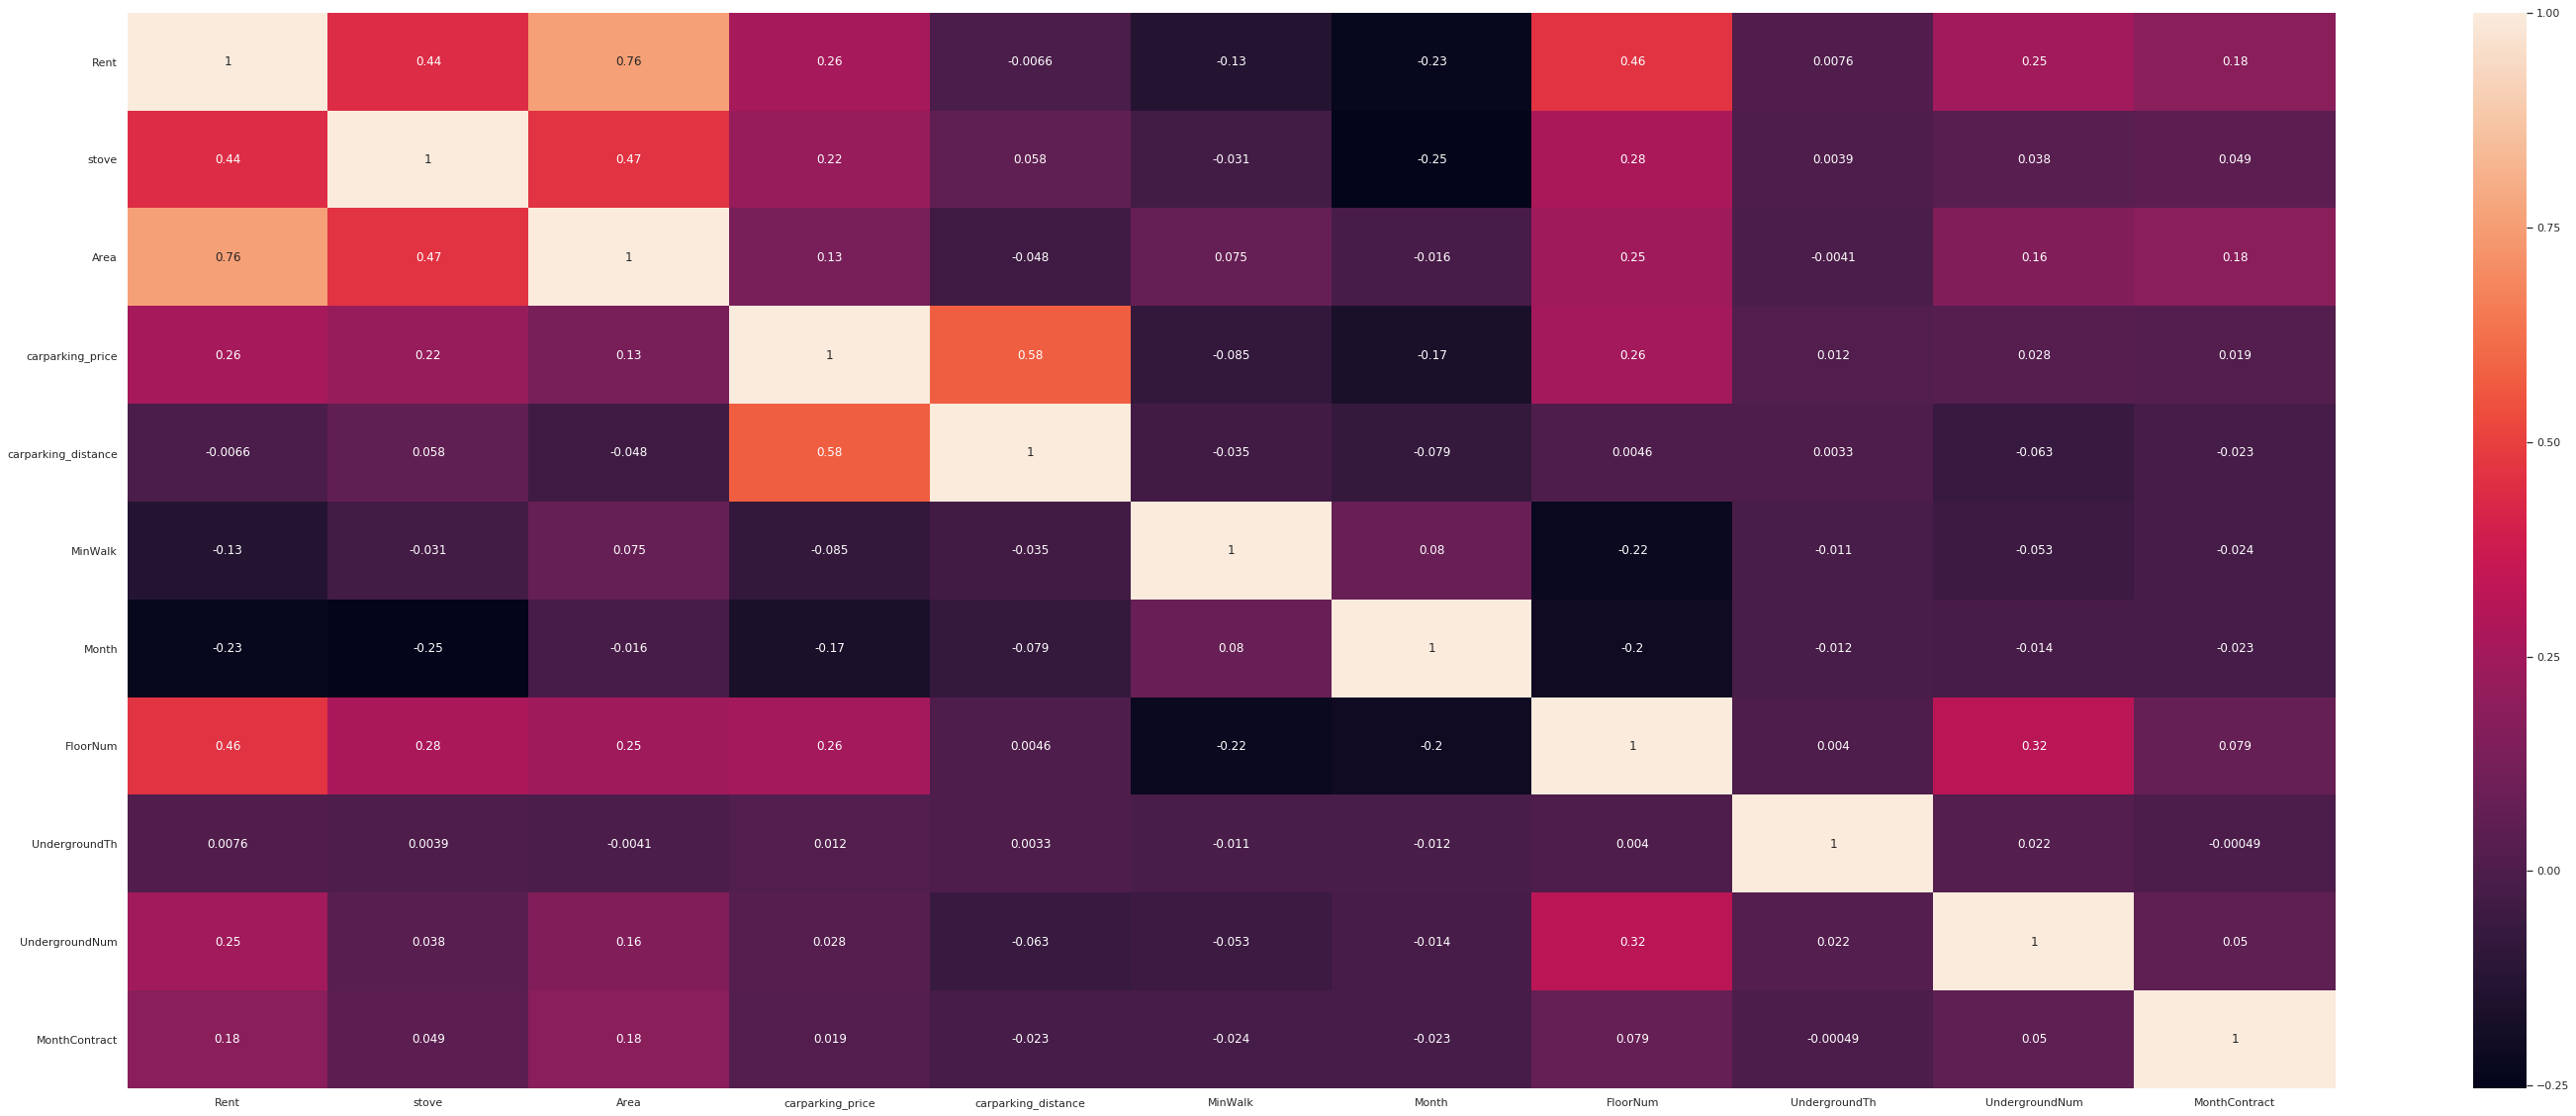

In [0]:
features = pd.concat([train, test]).reset_index(drop=True)
heat = features[['Rent','stove','Area','carparking_price','carparking_distance','MinWalk','Month','FloorNum','UndergroundTh','UndergroundNum','MonthContract']]
fig, ax = plt.subplots(figsize=(50,20))
sns.heatmap(heat.corr(),annot=True,ax=ax)

In [0]:
train['stove'].value_counts()

2    16226
1     9023
3     5547
0      621
4       51
Name: stove, dtype: int64

In [0]:
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

features = pd.concat([train, test]).reset_index(drop=True)
skew_features =  features[['stove','carparking_price','carparking_distance','MinWalk','Month','FloorNum','UndergroundTh','UndergroundNum','MonthContract']].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index
for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


In [0]:
test = features.iloc[len(train):, :]
train = features.iloc[:len(train), :]


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


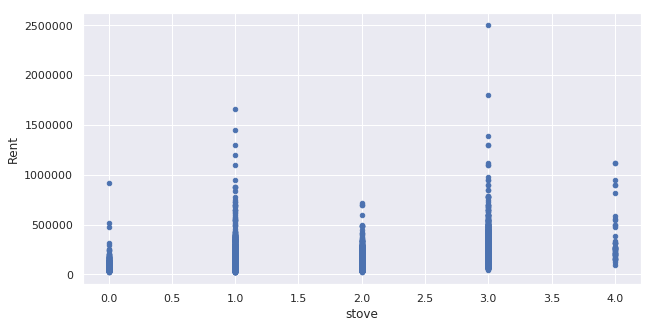

In [0]:
train.plot.scatter(
    x="stove", 
    y="Rent", 
    figsize = (10, 5)
)

<Figure size 1800x720 with 0 Axes>

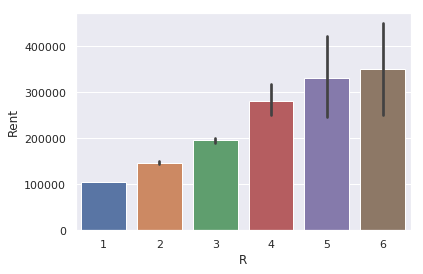

<Figure size 1800x720 with 0 Axes>

In [0]:
sns.set(font='IPAGothic')
sns.barplot(x=train['R'],y=train['Rent'],data=train)
plt.figure(figsize=(25,10))


In [0]:
sns.scatterplot(x="Area", y="tip", data=train)


In [0]:
facility_type = train['Facility'].dropna().str.split('\t').sum()
facility_type = [n.replace('／', '') for n in facility_type]
facility_type = list(set(facility_type))

In [105]:
facility_type

['フローリング',
 '',
 '専用庭',
 '出窓',
 'エアコン付',
 '都市ガス',
 '浄化槽',
 'プロパンガス',
 'バルコニー',
 '床下収納',
 '井戸',
 '防音室',
 'エレベーター',
 'タイル張り',
 'ペアガラス',
 '二世帯住宅',
 'オール電化',
 'ロフト付き',
 '24時間換気システム',
 'バリアフリー',
 'ガスその他',
 'ガス暖房',
 'ルーフバルコニー',
 '床暖房',
 '3面採光',
 '汲み取り',
 '洗濯機置場なし',
 '下水',
 '公営水道',
 '冷房',
 'ウォークインクローゼット',
 '石油暖房',
 '水道その他',
 '室外洗濯機置場',
 '二重サッシ',
 'シューズボックス',
 '室内洗濯機置場',
 'クッションフロア',
 '地下室',
 'トランクルーム',
 '敷地内ごみ置き場',
 '2面採光',
 '排水その他']

In [0]:
facility_type = facility_type[1:]

In [0]:
def one_hot(arr,col):
  for i in arr:
    train[i] = (train[col].str.find(i)!=-1)
    test[i] = (test[col].str.find(i)!=-1)

In [0]:
one_hot(facility_type,'Facility')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [0]:
train.head(2)

1stovetop  2stovetops  3stovetops  \
0          1           2           1   
1          1           1           1   

                                              Access      Age   Area  \
0  都営三田線\t西巣鴨駅\t徒歩4分\t\t埼京線\t板橋駅\t徒歩14分\t\t都電荒川線\...    9年9ヶ月  20.01   
1  都営大江戸線\t勝どき駅\t徒歩5分\t\t有楽町線\t月島駅\t徒歩9分\t\t日比谷線\...  44年10ヶ月  16.50   

                                               Bath City Contract      D  \
0  専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄便座   北区      2年間  False   
1                             専用トイレ／\tシャワー／\t温水洗浄便座  中央区      2年間  False   

  Direction                                           Facility    Floor  \
0        南東  エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...  1階／12階建   
1         南  エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...  5階／10階建   

   FloorNum  House     IH                            Internet      K  \
0  1.718775  False  False  インターネット対応／\tCATV／\tCSアンテナ／\tBSアンテナ   True   
1  1.646224  False  False                           インターネット対応  False   

                           Kitchen      L    Line     Location  Lshapekitchen  \
0  ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯  False   都営三田線  東京都北区滝野川３丁目          False   
1          ガスコンロ／\tシステムキッチン\t／\t給湯  False  都営大江戸線  東京都中央区月島３丁目          False   

       Material   MinWalk      Month  MonthContract  NewConstr  \
0  RC（鉄筋コンクリート）  1.953384  22.561531        1.61819      False   
1           鉄骨造  2.224552  53.666549        1.61819      False   

                          Parking  R     Rent      S Station  \
0                       a駐輪場\t空有a  1  75000.0  False    西巣鴨駅   
1  a駐輪場\t空有\ta駐車場\t無\taバイク置き場\t無a  1  76000.0  False    勝どき駅   

                                            Surround Type  UndergroundNum  \
0  【小学校】 495m\t【大学】 461m\t【小学校】 962m\t【公園】 1103m\...   1K             0.0   
1                                       【スーパー】 1283m   1R             0.0   

   UndergroundTh  Year  YearContract   bank  bath  bathtoilet bikeparking  \
0            0.0     9             2  False  専用バス        True          空有   
1            0.0    44             2  False  バスなし       False          空有   

   bsantenna  cable carparking  carparking_distance  carparking_price   catv  \
0       True  False          無                  0.0               0.0   True   
1      False  False          無                  0.0               0.0  False   

   cleaning  coinparking  counterkitchen  ...  separatekitchen  shower  stove  \
0     False        False           False  ...            False    True      2   
1     False        False           False  ...            False    True      1   

   supermarket  systemkitchen  toilet   univ  unknown  warmseat  washstand  \
0         True           True   専用トイレ   True    False      True      False   
1         True           True   専用トイレ  False    False      True      False   

   フローリング    浄化槽  二世帯住宅  ペアガラス   石油暖房  室外洗濯機置場   2面採光  ガスその他   3面採光   汲み取り  \
0    True  False  False  False  False    False  False  False  False  False   
1    True  False  False  False  False    False  False  False  False  False   

   オール電化     井戸  シューズボックス   都市ガス  24時間換気システム  二重サッシ  エレベーター  洗濯機置場なし  \
0  False  False      True   True       False  False    True    False   
1  False  False      True  False       False  False    True    False   

   ウォークインクローゼット     出窓    地下室  ロフト付き  バリアフリー     冷房  敷地内ごみ置き場  ルーフバルコニー  \
0         False  False  False  False   False  False      True     False   
1         False  False  False  False   False  False      True     False   

     床暖房  プロパンガス  バルコニー     下水  タイル張り    専用庭  トランクルーム   床下収納   ガス暖房  室内洗濯機置場  \
0  False   False   True   True  False  False    False  False  False     True   
1  False   False   True  False   True  False    False  False  False     True   

   水道その他   公営水道    防音室  クッションフロア  排水その他  エアコン付  
0  False   True  False     False  False   True  
1  False  False  False     False  False   True  

[2 rows x 135 columns]

In [0]:
#Label follow these mapping 
train["City"] = train.City.replace({'葛飾区' : 1, '足立区':2,'江戸川区':3,'板橋区':4,'練馬区':5,'杉並区':6,'北区':7,
                                    '中野区':8, '大田区':9,	'豊島区':10,'世田谷区':11,	'墨田区':12,'荒川区':13,'品川区':14,
                                    '江東区':15, '台東区':16,'文京区':17,'新宿区':18,'目黒区':19, '渋谷区':20, '中央区':21,
                                    '千代田区':22, '港区':23})


In [0]:
def target_encode(train,df,target,categorical):
    for col in categorical:
        tmp = pd.DataFrame(train.groupby(col)[target].agg(["mean"])).fillna(-999)
        tmp.reset_index(inplace=True)
        tmp.columns = [col,col+"_mean"]
        df = pd.merge(df,tmp,how="left",on=col)
        del(tmp)
    return df


In [0]:
train['target'] = (train['Rent'] >= train['Rent'].mean()).astype(int)
from sklearn.model_selection import KFold

kf = KFold(n_splits = 10,shuffle=False)
categorical = ['City','Station','Line','Direction','Material','bath','toilet','carparking','bikeparking','motorparking']

dfs = []
for train_index, test_index in kf.split(train):
    print(train_index,test_index)
    tmp = target_encode(train.iloc[train_index],train.iloc[test_index],"target",categorical)
    dfs.append(tmp)

return_df = pd.concat(dfs,axis=0)

#for col in categorical:
#  return_df[col] = return_df.groupby(col)[col+'_mean'].transform('mean')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


[ 3147  3148  3149 ... 31465 31466 31467] [   0    1    2 ... 3144 3145 3146]
[    0     1     2 ... 31465 31466 31467] [3147 3148 3149 ... 6291 6292 6293]
[    0     1     2 ... 31465 31466 31467] [6294 6295 6296 ... 9438 9439 9440]
[    0     1     2 ... 31465 31466 31467] [ 9441  9442  9443 ... 12585 12586 12587]
[    0     1     2 ... 31465 31466 31467] [12588 12589 12590 ... 15732 15733 15734]
[    0     1     2 ... 31465 31466 31467] [15735 15736 15737 ... 18879 18880 18881]
[    0     1     2 ... 31465 31466 31467] [18882 18883 18884 ... 22026 22027 22028]
[    0     1     2 ... 31465 31466 31467] [22029 22030 22031 ... 25173 25174 25175]
[    0     1     2 ... 31465 31466 31467] [25176 25177 25178 ... 28319 28320 28321]
[    0     1     2 ... 28319 28320 28321] [28322 28323 28324 ... 31465 31466 31467]


In [0]:
return_df = return_df.reset_index()

In [0]:
for col in categorical:
  return_df[col+'_mean'] = return_df.groupby(col)[col+'_mean'].transform('mean')
  test = test.merge(return_df[[col,col+'_mean']].groupby(col).max(), how="left",on=col)


In [0]:
train = return_df.drop(['index','id'],axis=1)

In [0]:
train.head(1)

1stovetop  2stovetops  3stovetops  \
0          1           2           1   

                                              Access    Age   Area  \
0  都営三田線\t西巣鴨駅\t徒歩4分\t\t埼京線\t板橋駅\t徒歩14分\t\t都電荒川線\...  9年9ヶ月  20.01   

                                               Bath City Contract      D  \
0  専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄便座   北区      2年間  False   

  Direction                                           Facility    Floor  \
0        南東  エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...  1階／12階建   

   FloorNum  House     IH                            Internet     K  \
0  1.718775  False  False  インターネット対応／\tCATV／\tCSアンテナ／\tBSアンテナ  True   

                           Kitchen      L   Line     Location  Lshapekitchen  \
0  ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯  False  都営三田線  東京都北区滝野川３丁目          False   

       Material   MinWalk      Month  MonthContract  NewConstr    Parking  R  \
0  RC（鉄筋コンクリート）  1.953384  22.561531        1.61819      False  a駐輪場\t空有a  1   

      Rent      S Station                                           Surround  \
0  75000.0  False    西巣鴨駅  【小学校】 495m\t【大学】 461m\t【小学校】 962m\t【公園】 1103m\...   

  Type  UndergroundNum  UndergroundTh  Year  YearContract   bank  bath  \
0   1K             0.0            0.0     9             2  False  専用バス   

   bathtoilet bikeparking  bsantenna  cable carparking  carparking_distance  \
0        True          空有       True  False          無                  0.0   

   carparking_price  catv  cleaning  coinparking  counterkitchen  ...    浄化槽  \
0               0.0  True     False        False           False  ...  False   

   二世帯住宅  ペアガラス   石油暖房  室外洗濯機置場   2面採光  ガスその他   3面採光   汲み取り  オール電化     井戸  \
0  False  False  False    False  False  False  False  False  False  False   

   シューズボックス  都市ガス  24時間換気システム  二重サッシ  エレベーター  洗濯機置場なし  ウォークインクローゼット     出窓  \
0      True  True       False  False    True    False         False  False   

     地下室  ロフト付き  バリアフリー     冷房  敷地内ごみ置き場  ルーフバルコニー    床暖房  プロパンガス  バルコニー  \
0  False  False   False  False      True     False  False   False   True   

     下水  タイル張り    専用庭  トランクルーム   床下収納   ガス暖房  室内洗濯機置場  水道その他  公営水道    防音室  \
0  True  False  False    False  False  False     True  False  True  False   

   クッションフロア  排水その他  エアコン付  target  City_mean  Station_mean  Line_mean  \
0     False  False   True       0    0.21891      0.372378   0.317511   

   Direction_mean  Material_mean  bath_mean  toilet_mean  carparking_mean  \
0         0.43934       0.473719   0.393191     0.385502         0.282813   

   bikeparking_mean  motorparking_mean  
0           0.43328           0.331155  

[1 rows x 145 columns]

In [0]:
drop_cat_columns = ['Location','Access','Station','Line','Direction','Material','Type','Age','Floor',
                   'Bath','Kitchen','Internet','Facility','Parking','Surround','Contract',
                   'City','bath','toilet','carparking','bikeparking','motorparking','1stovetop','3stovetops','2stovetops','morethan4stoves','Year','YearContract']
train = train.drop(drop_cat_columns,axis = 1)
test = test.drop(drop_cat_columns,axis = 1)

In [0]:
train = train.drop('target',axis = 1)
test = test.drop('id',axis = 1)

In [0]:
train.head(1)

Area      D  FloorNum  House     IH     K      L  Lshapekitchen   MinWalk  \
0  20.01  False  1.718775  False  False  True  False          False  1.953384   

       Month  MonthContract  NewConstr  R     Rent      S  UndergroundNum  \
0  22.561531        1.61819      False  1  75000.0  False             0.0   

   UndergroundTh   bank  bathtoilet  bsantenna  cable  carparking_distance  \
0            0.0  False        True       True  False                  0.0   

   carparking_price  catv  cleaning  coinparking  counterkitchen  csantenna  \
0               0.0  True     False        False           False       True   

   department  dressing  drugstore  dryer  electricstove  fixedterm  \
0       False     False       True   True          False      False   

   freeusage  fridge  gasstove  generalhospital  highspeed  hospital  \
0      False   False      True            False      False     False   

   hotwatersupply  installedstove  internetcompatible  kindergarten  konbini  \
0            True           False                True         False     True   

   library  memorial  monthlyparkinglot  opticalfiber  park  postoffice  \
0    False     False              False         False  True        True   

   primaryschool  ...  フローリング    浄化槽  二世帯住宅  ペアガラス   石油暖房  室外洗濯機置場   2面採光  \
0           True  ...    True  False  False  False  False    False  False   

   ガスその他   3面採光   汲み取り  オール電化     井戸  シューズボックス  都市ガス  24時間換気システム  二重サッシ  \
0  False  False  False  False  False      True  True       False  False   

   エレベーター  洗濯機置場なし  ウォークインクローゼット     出窓    地下室  ロフト付き  バリアフリー     冷房  \
0    True    False         False  False  False  False   False  False   

   敷地内ごみ置き場  ルーフバルコニー    床暖房  プロパンガス  バルコニー    下水  タイル張り    専用庭  トランクルーム  \
0      True     False  False   False   True  True  False  False    False   

    床下収納   ガス暖房  室内洗濯機置場  水道その他  公営水道    防音室  クッションフロア  排水その他  エアコン付  \
0  False  False     True  False  True  False     False  False   True   

   City_mean  Station_mean  Line_mean  Direction_mean  Material_mean  \
0    0.21891      0.372378   0.317511         0.43934       0.473719   

   bath_mean  toilet_mean  carparking_mean  bikeparking_mean  \
0   0.393191     0.385502         0.282813           0.43328   

   motorparking_mean  
0           0.331155  

[1 rows x 116 columns]

<Figure size 3600x1440 with 0 Axes>

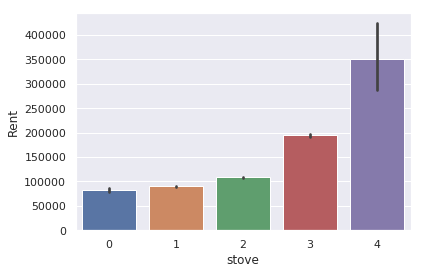

<Figure size 3600x1440 with 0 Axes>

In [0]:
sns.set(font='IPAGothic')
sns.barplot(x=train['stove'],y=train['Rent'],data=train)
plt.figure(figsize=(50,20))


In [0]:
for dataset in train_test_data:
    dataset['sta'] = dataset['Access'].str.replace('\t','')


In [0]:
for dataset in train_test_data:
    for i in station:
        dataset[i+'walk'] = dataset['sta'].str.extract('({}\t*?徒歩\d*分)'.format(i))
        dataset[i+'walk'] = dataset[i+'walk'].str.extract('(徒歩\d*分)')
        dataset[i+'walk'] = dataset[i+'walk'].str.extract('(\d*分)')
        dataset[i+'walk'] = dataset[i+'walk'].str.extract('(\d*)').fillna('999999')
        dataset[i+'walk'] = 1/(dataset[i+'walk'].astype(int))


In [0]:
#新小岩駅/バス(4分)
for dataset in train_test_data:
    for i in station:
        dataset[i+'bus'] = dataset['sta'].str.extract('({}\t*?.バス.\d*分.)'.format(i))
        dataset[i+'bus'] = dataset[i+'bus'].str.extract('(.バス.\d*分.)')
        dataset[i+'bus'] = dataset[i+'bus'].str.extract('(\d*分)')
        dataset[i+'bus'] = dataset[i+'bus'].str.extract('(\d*)').fillna('999999')
        dataset[i+'bus'] = 1/(dataset[i+'bus'].astype(int))


In [0]:
for dataset in train_test_data:
  for i in station:
    dataset[i+'movetime'] = dataset[i+'walk'] + dataset[i+'bus']


In [0]:
for i in station:
    train = train.drop(i+'walk',axis=1)
    train = train.drop(i+'bus',axis=1)
    test = test.drop(i+'walk',axis=1)
    test = test.drop(i+'bus',axis=1)


In [0]:
surrounding_list = ['小学校', '大学', '公園', '飲食店', 'スーパー', 'コンビニ', 'ドラッグストア', '郵便局', '病院', '図書館', 
                    '銀行', '学校', '幼稚園・保育園', '総合病院', 'デパート', 'レンタルビデオ', 'クリーニング', 'コインパーキング',
                    '月極駐車場']
for dataset in train_test_data:
  for i in surrounding_list:
      #dataset[n + '_distance'] = dataset['Surrounding'].str.extract(r'【' + n + '】\s*(\d+?)m').fillna('9999').astype(int)
      dataset[i + 'count'] = dataset['Surround'].fillna('').map(lambda x: x.count(i))


In [0]:
train.to_csv('train (2).csv')
test.to_csv('test (2).csv')